# PHY 480/905 Semester Project
---

**Project Title:** Computationally Modeling and Optimizing a Tuned Mass Damper <br>
**Project Authors:** Patrick Tutt & Steven VanCamp <br>
**Last Updated:** 28/4/23 <br>

# ***EXTREMELY IMPORTANT: YOU MUST UPLOAD THE FULL DELIVERABLES FOLDER TO COLAB IN ORDER TO RUN THE BELOW CODE***  

This was done in order to simplfy the notebook length. 

# Intro
---

Tuned mass dampers (TMDs) are mechanical devices that are used to reduce the vibrations of structures
subjected to dynamic loads. Harmonic absorbers or seismic dampers are other names for these types of devices. They
are typically used in tall buildings, long-span bridges, and offshore structures that are exposed to wind, earthquakes,
and other environmental forces. These external factors induce vibrations that can cause harm to the building structure
and jeopardize the safety of occupants. Structures like bridges or buildings have a natural frequency at which they
oscillate. Coupling this fundamental mode with excitation from an earthquake or other factor, the building may be
excited to a higher-order mode where vibrations are more dangerous. The basic principle of a TMD is to dampen
the harmonic motion of a structure by having a component of the structure oscillate out of phase with the harmonic
motion. The desired effect is to see a reduction of the oscillation amplitude in time. [1].

One of the many advantages of TMDs is their small mass in comparison to the overall size of the structure
they are installed within. This is especially true for Taipei 101, where the TMD weighs 660 metric tons. Please refer to the project report for images of the Taipei 101. Fundamentally, the TMD here can be represented as a mass coupled
with a spring. To begin our computational model of a TMD, this basic model is where we will start. From there, we
will extend the mathematical description and computational model to a multi-story building.

With the need to understand TMDs properly motivated, a discussion of the important physical questions we
want to answer can be had. Our goals in this project are as follows:
- Can we model a simple coupled-mass spring system with damped oscillations?
- Can we extend this model to a generalized case of a one-dimensional building?
- Can we optimize the parameters of the TMD for this one-dimensional building case?

# Methodology
---

### Mathematical Basis

There are two mathematical models that form the basis for our project. First, a simple coupled-mass spring system that models a very simple TMD. Second, a generalization of that mathematical base to a multi-story building in 1D. Each model and their corresponding ODEs are shown below. More description and motivation for using these ODEs are discussed in the project report. For each case, looking at the picture representation allows you to write down the ODE. These are 2nd order ODEs so decoupling of the system is required to reach a series of first order ODEs. These series of first order ODEs can be solved using typical numerical integration methods. 

Coupled mass spring system: 

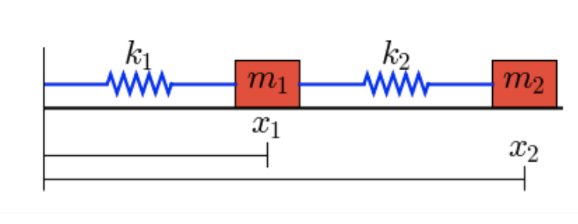

And associated ODE:

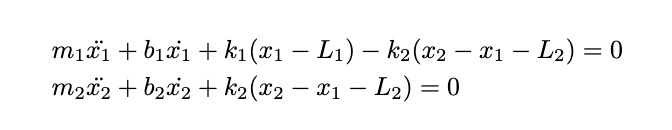

1D building model:

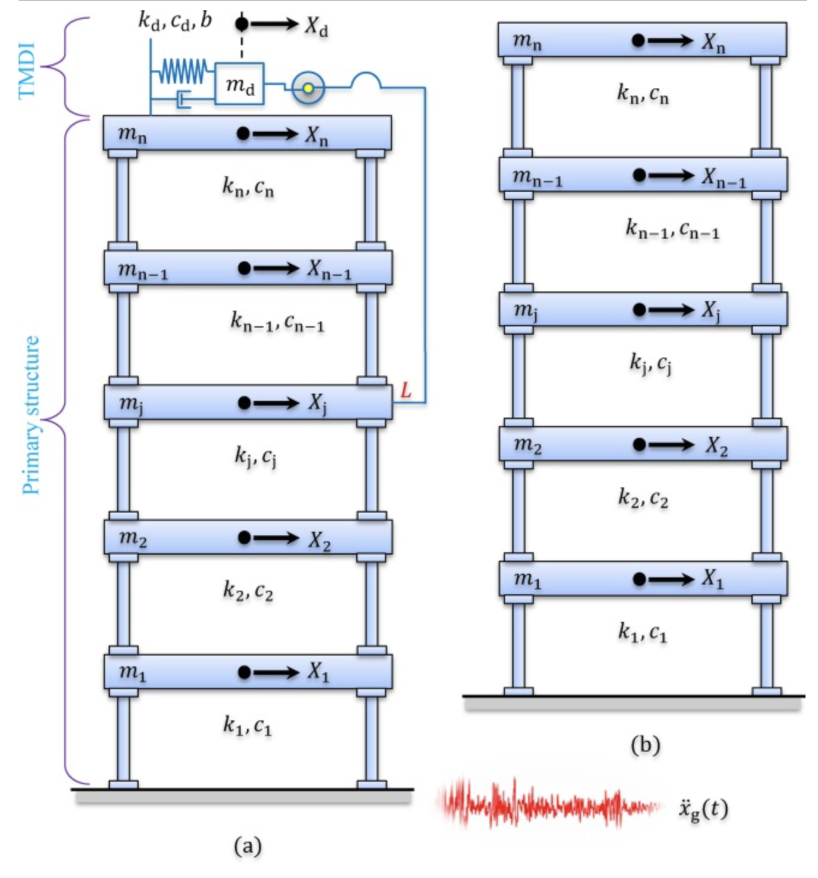

Associated ODEs:

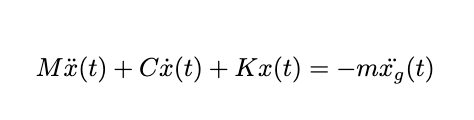

M, C, and K are matrices that contain the associated mass, stiffness, and spring constant for each floor and the damper. Each of these matrices also contains information about how the coupling between floors functions. Please see the project report for the form of C, K and M. The small m represents a row vector of the masses of each floor. The final term xg describes the input signal ground acceleration that pertrubs the building.

Integration methods are now required to solve these equations. In each case, you can decouple the system of 2nd order ODEs into a series of first order ODEs than can be solved with typical integration techniques. For the simple coupled-mass spring system, the odeint python package may be used. For the building case, a Runge-Kutta 4 method will be utilized written in C++. 

### Code

In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pds
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree

### 1.1) Model 1: Coupled Spring Masses

### 1.1.1) Simulation Results

In [ ]:
%%bash
fname_res="results/sim_spring_res.txt"

mass_building=10.0
mass_dampner=1.0

k_building=8.0
k_dampner=40.0

fr_building=0.5
fr_dampner=0.8

run_time=50.0

g++ -O3 -o sim_spring.exe src/sim_spring.cpp

./sim_spring.exe $fname_res $mass_building $mass_dampner $run_time

rm sim_spring.exe

In [ ]:
data_tmd = np.genfromtxt('results/sim_spring_res.txt', dtype='f8', delimiter=',', usecols=[0,1,2,3])

data_range = np.linspace(0,50, len(data_tmd[:,0]))

fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

ax1.plot(data_range, data_tmd[:,0], label='Building')
ax1.plot(data_range, data_tmd[:,2], label='Dampener')

ax1.legend()

ax1.set_title('Position of Spring Masses, Dampning')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Mass Position [m]')

### 1.2) Model 2: Building

### 1.2.1) Simulation Results

In [ ]:
%%bash
fname_seis_data="init_conds/elcentro_NS.dat.txt"
fname_init_conds="init_conds/init_cond_build.txt"
fname_init_conds_no_damp="init_conds/init_cond_build_no_damp.txt"
fname_damp_res="results/sim_build_res_damp.txt"
fname_no_damp_res="results/sim_build_res_no_damp.txt"

rm $fname_damp_res
rm $fname_no_damp_res

g++ -O3 -o sim_building.exe src/sim_building.cpp

./sim_building.exe $fname_init_conds $fname_seis_data $fname_damp_res
./sim_building.exe $fname_init_conds_no_damp $fname_seis_data $fname_no_damp_res

rm sim_building.exe

In [ ]:
quake_data = np.genfromtxt('init_conds/elcentro_NS.dat.txt', delimiter=' ', usecols=(0,1), dtype='f8')

data_damp = np.genfromtxt('results/sim_build_res_damp.txt', delimiter=',', skip_header=1, dtype='f8')
data_no_damp = np.genfromtxt('results/sim_build_res_no_damp.txt', delimiter=',', skip_header=1, dtype='f8')

data_damp = data_damp[:,:-1]
data_no_damp = data_no_damp[:,:-1]

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot input seismic signal/data
ax1.plot(quake_data[:,0], quake_data[:,1])

ax1.set_xlim(0,30)

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Force [$m/s^{2}$]')
ax1.set_title('Force Applied On The Ground Floor Over Time')

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot floor displacement
for i in range(len(data_damp[0])-2):
    if (i%2 == 0):
        ax1.plot(quake_data[:,0], data_damp[:,i], label=f'Floor {i/2}')

ax1.plot(quake_data[:,0], data_damp[:,len(data_damp[0])-2], 
         label='Dampener', c='black', linestyle='--', alpha=0.3)

ax1.set_xlim(0,30)

# ax1.legend()

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Displacement [$m$]')
ax1.set_title('1D Displacement Of Each Floor')

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot top floor displacement for the cases where there is dampenign and low dampening
ax1.plot(quake_data[:,0], data_no_damp[:,len(data_no_damp[0])-4], 
         label=f'No Dampener', alpha=0.4, color='black',
         linestyle='--')

ax1.plot(quake_data[:,0], data_damp[:,len(data_damp[0])-4], 
         label=f'Reference Dampener Parameters')

ax1.set_xlim(0,30)

ax1.legend()

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Displacement [$m$]')
ax1.set_title('1D Displacement Of Each Floor')

### 1.2.2) Optimization Results

#### Generate and load MCMC results

In [ ]:
%%bash
fname_init_conds="init_conds/init_cond_build.txt"
fname_xg_data="init_conds/elcentro_NS.dat.txt"
fname_optim_conds="init_conds/init_cond_optim.txt"
fname_output="results/optim_build_mcmc.txt"

rm $fname_output
rm "results/mcmc_log.txt"

g++ -O3 -o optim_building.exe src/optim_building.cpp

./optim_building.exe $fname_init_conds $fname_xg_data $fname_optim_conds $fname_output

rm optim_building.exe

In [ ]:
mcmc_data = np.genfromtxt('results/optim_build_mcmc.txt', delimiter=', ', dtype='f8')

m = mcmc_data[:,0]
k = mcmc_data[:,1]
c = mcmc_data[:,2]

#### Compare prior assumptions to results

In [ ]:
def gaus_prior(x, prior, sigma):
    y = (2*np.pi*sigma)**(-0.5) * np.exp((x-prior)**(2) / (2*sigma)**(2))

    return y

n_x = 1000

m_a, m_b = 0.0, 0.2
m_prior_range = np.linspace(m_a, m_b, n_x)
m_prior = gaus_prior(m_prior_range, 0.05, 0.03)

k_a, k_b = 1.5, 3.5
k_prior_range = np.linspace(k_a, k_b, n_x)
k_prior = gaus_prior(k_prior_range, 3.7, 1.5)

c_a, c_b = 0.0, 0.7
c_prior_range = np.linspace(c_a, c_b, n_x)
c_prior = gaus_prior(c_prior_range, 0.197, 0.10)

In [ ]:
n_bins = 50
f_size = 15
orien = 'vertical'

fig, ax = plt.subplots(3,1)
fig.set_size_inches(5,15)

fig.suptitle("Comparing Priors to Posteriors", fontsize=f_size)

# setup labels
ax[0].set_xlabel('m $[\%M_{tot}]$', fontsize=f_size)
ax[1].set_xlabel('k $[MN/m]$', fontsize=f_size)
ax[2].set_xlabel('c $[MN*s/m]$', fontsize=f_size)

# plot triangle plot
ax[0].hist(m, bins=n_bins, orientation=orien)
ax[0].plot(m_prior_range, m_prior, label='prior')
ax[0].legend()

ax[1].hist(k, bins=n_bins, orientation=orien)
ax[1].plot(k_prior_range, k_prior, label='prior')
ax[1].legend()

ax[2].hist(c, bins=n_bins, orientation=orien)
ax[2].plot(c_prior_range, c_prior, label='prior')
ax[2].legend()

fig.tight_layout()


#### Make Triptych plot of optimization parameters

In [ ]:
n_bins = 50
f_size = 15
orien = 'horizontal'

fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)

fig.suptitle('Triptych: MCMC Parameter Likelyhoods', fontsize=f_size*1.5)

# setup labels
ax[2,0].set_xlabel('m $[\%M_{tot}]$', fontsize=f_size)
ax[2,1].set_xlabel('k $[MN/m]$', fontsize=f_size)
ax[2,2].set_xlabel('c $[MN*s/m]$', fontsize=f_size)

ax[0,0].set_ylabel('m $[\%M_{tot}]$', fontsize=f_size)
ax[1,0].set_ylabel('k $[MN/m]$', fontsize=f_size)
ax[2,0].set_ylabel('c $[MN*s/m]$', fontsize=f_size)

# plot triangle plot
ax[0,0].hist(m, bins=n_bins, orientation=orien)

ax[1,0].hist2d(m, k, bins=n_bins, norm=LogNorm())
ax[1,1].hist(k, bins=n_bins, orientation=orien)

ax[2,0].hist2d(m, c, bins=n_bins, norm=LogNorm())
ax[2,1].hist2d(k, c, bins=n_bins, norm=LogNorm())
ax[2,2].hist(c, bins=n_bins, orientation=orien)

# delete upper triangle
fig.delaxes(ax[0,2])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,2])

fig.tight_layout()


#### Make 3d volumetric plot of all parameter space

In [ ]:
m_min, m_max = np.min(mcmc_data[:,0]), np.max(mcmc_data[:,0])
k_min, k_max = np.min(mcmc_data[:,1]), np.max(mcmc_data[:,1])
c_min, c_max = np.min(mcmc_data[:,2]), np.max(mcmc_data[:,2])

m_range = np.linspace(m_min, m_max, 10)
k_range = np.linspace(k_min, k_max, 10)
c_range = np.linspace(c_min, c_max, 10)

m_grid, k_grid, c_grid = np.meshgrid(m_range, k_range, c_range)

grid_values = np.zeros_like(m_grid).flatten() # grid containing density value for each grid point

grid_tree = np.zeros((len(m_grid.flatten()),3))
grid_tree[:,0] = m_grid.flatten()
grid_tree[:,1] = k_grid.flatten()
grid_tree[:,2] = c_grid.flatten()

grid_point_tree = cKDTree(grid_tree)
true_point_tree = cKDTree(mcmc_data[:,:3])

n_grid_poitns = len(grid_tree)

r_bin = 0.1

kd_search_res = grid_point_tree.query_ball_tree(true_point_tree, r=r_bin)

for i in range(len(kd_search_res)):
    grid_values[i] = len(kd_search_res[i])

grid_values = np.reshape(grid_values, np.shape(m_grid)).flatten()

grid_values = grid_values/np.linalg.norm(grid_values)

#### Get best parameter values from this parameter space

In [ ]:
vals_index=np.argwhere(grid_values==grid_values.max())

m_best = grid_tree[vals_index[0,0],0]
k_best = grid_tree[vals_index[0,0],1]
c_best = grid_tree[vals_index[0,0],2]

print('The "best" value for M was:', round(m_best,6))
print('The "best" value for k was:', round(k_best,6))
print('The "best" value for c was:', round(c_best,6))

#### Plot MCMC parameter space in volumetric 3d

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=[m_best],
        y=[k_best],
        z=[c_best],
        marker=dict(
            size=10
        )
    )
)

fig.add_trace(
    go.Volume(
        x=m_grid.flatten(),
        y=k_grid.flatten(),
        z=c_grid.flatten(),
        value=grid_values,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=30, # needs to be a large number for good volume rendering
        colorscale='Viridis'
    )
)

fig.update_layout(
    scene = dict(
        xaxis = dict(title='m [%M_{tot}]'),
        yaxis = dict(title='k [MN/m]'),
        zaxis = dict(title='c [MN*s/m]'),
        aspectmode='cube'
    )
)

fig.show()
fig.write_html('../results/mcmc_scatter.html')

In [ ]:
print('The "best" value for M was:', round(m_best,6))
print('The "best" value for k was:', round(k_best,6))
print('The "best" value for c was:', round(c_best,6))

#### Run Building Simulation With "Optimal" Parameters

In [ ]:
%%bash
fname_init_conds="init_conds/init_cond_build.txt"
fname_seis_data="init_conds/elcentro_NS.dat.txt"
fname_damp_optim="results/sim_build_res_optim.txt"

rm $fname_damp_optim

# "damp_m_perc" represents what percent the total building mass will 
# be multiplied by to get the mass of the dampener
damp_m=0.045323
damp_k=2.775897
damp_c=0.212485

g++ -O3 -o sim_building.exe src/sim_building.cpp

./sim_building.exe $fname_init_conds $fname_seis_data $fname_damp_optim \
                   $damp_m $damp_k $damp_c

rm sim_building.exe

In [ ]:
data_optim = np.genfromtxt('results/sim_build_res_optim.txt', delimiter=',', skip_header=1, dtype='f8')

data_optim = data_optim[:,:-1]

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot top floor displacement for the cases where there is dampenign and low dampening
ax1.plot(quake_data[:,0], data_no_damp[:,len(data_no_damp[0])-4], 
         label=f'No Dampener', alpha=0.4, color='black',
         linestyle='--')

ax1.plot(quake_data[:,0], data_damp[:,len(data_damp[0])-4], 
         label=f'Reference Dampener Parameters', alpha=0.9)

ax1.plot(quake_data[:,0], data_optim[:,len(data_optim[0])-4], 
         label=f'MCMC Dampener Parameters', alpha=0.9)

ax1.set_xlim(0,30)

ax1.legend()

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Displacement [$m$]')
ax1.set_title('1D Displacement of The Top Floor')

# Results & Discussion
---

### Mass-spring results

As discussed above, there are two relevant models. The first is a coupled mass-spring system and
the second is a more complicated formulation of a one-dimensional building. Simulations were run for both systems
and the position of the damper and floors (when relevant) are plotted. Minimal results are shown for the mass-spring
system, as this model only serves as a way of understanding the basic principles of a TMD. Multiple simulations were
run for the building case and optimization was done to find the best parameters of the damper (md, kd, and cd).

For a coupled mass-spring system, python tools like odeint are capable of handling the decoupling of second-
order ODEs to a series of first-order ODEs. Simulation results for this system are based on mass-spring equations above and are
contained within the above figures. In this simulation, the values of the relevant parameters are shown below:
- m1 = 10.0; m2 = .3
- k1 = 8.0; k2 = 3.0
- b1 = .2; b2 = .8

Complex analysis and optimization are not required for this case since we are merely trying to observe qualitatively if the damper is working. To do this, we observe the behavior of the ”building” which is represented by m1
in our pictorial representation above. Just after t = 0, the building reaches the highest amplitude of the
entire plot. As time is allowed to progress, we see that the amplitude of the building is damped from the maximum
amplitude it originally reaches. In combination with this, we see that the damper also begins to oscillate less over
time. With these two pieces of information together, we can confidently say that the damper is working, although it
may not be the most effective damping.



### Optimization results

As part of our project, we are optimizing the parameters that define the behavior of a TMD coupled to a multi-story building. To complete this an MCMC algorithm is used following the methodology described above. This does require that the simulation as described above is complete and working so that the results can be compared to a desired state at each MCMC iteration. For our problem, we defined the desired state of the system to be where the top floor displacement is described by the equation below. Where $\Delta D_{top}$ is the displacement of the top floor.

$$\Delta D_{top}(t) = 0$$

The required inputs for the MCMC algorithm are as follows: $N_{iter}$, $N_{burn}$, $\sigma_{data}$, $p^{i}_{prior}$, $p^{i}_{var}$, $p^{i}_{guess}$, $p^{i}_{\delta}$. $N_{iter}$ is the number of iterations the MCMC algorithm will take and $N_{burn}$ is the number of iterations (as a percentage) the algorithm will throw away at the beginning as the walker is finding the optimal region. These were set to $1E5$ and $10\%$ respectively. $\sigma_{data}$ is the estimated error on the desired state, and was set to $0.2$. The remaining parameters are required for each TMD parameter being optimized, so in our case $m_{d}$, $k_{d}$, and $c_{d}$. These describe the prior related to that parameter and the initial guess and how much the MCMC algorithm can vary that parameter each iteration. The parameters used in our project can be found in the file "init_conds\init_cond_optim.txt".

The results from our MCMC algorithm are shown as a triptych above. Each component of the figure is a posterior distribution related to 1 or 2 parameters. It can be seen that the parameter space defined by c and m, which is shown in the bottom left of the triptych, has a posterior distribution that is well-defined. However, the posterior distribution of $k$ is not well defined. This makes picking the optimal parameter values slightly more complicated.

To facilitate picking the optimal parameter values a full parameter space was created and binned. Since we have 3 parameters a 3d visualization can be made, this is shown above. The bins were assigned a value that corresponds to the number of points within the bin volume. The optimal parameter values were chosen as those defined by the bin with the highest value. This corresponds to the parameter space that the MCMC algorithm spends the most time in. The optimal dampener parameters were found to be the following: $m_{d} = 0.0453$, $k_{d} = 2.7758$, $c_{d} = 0.2124$.

### 1D Building result

With parameters md, kd, and cd optimized using MCMC, comparisons can be made between simulation results
for the 1D building case. In each case, ten building floors were simulated, including the damper. The figure above  contains the 1D displacement of the top floor for a ”no damp” case and a case where reference parameters are used. These reference parameters were obtained from a literature review and were found to be the best parameters using an optimized transfer function [9]. The reference parameters taken from the literature are contained in the project report.
Note that ”floor” refers to the mass, spring constant, and stiffness factor for all floors but the damper. Also
note that the md value is not optimized, but rather is taken to be 3% of the total building mass. Investigating the figure above more closely, qualitatively it can be seen that the no dampener and dampened case are relatively similar for the first
5 seconds. There doesn’t appear to be any significant reduction in amplitude during this period. After this initial 5
seconds, the dampening effects are clear. The dampened case, colored in blue, shows significant amplitude reductions
compared to the no-dampener case. These reductions can be as large as 0.008 meters like at the t = 10 seconds mark
where the dampened building position at the top floor is nearly 0. Reduction in oscillation amplitude is seen from
beyond 5 seconds until the end of the simulation run at 30 seconds.

Using the optimization results, the simulation was rerun and compared with the optimal
parameters obtained from literature and the no dampening case. This simulation result is shown in the above figures. Similar
to the previous simulation, within 5 seconds the no damper, reference parameters, and optimized parameters cases
all have roughly the same displacement. As expected, as time is allowed to progress from 5 to 30, the no damper
case has a much higher amplitude compared to the other two cases. Comparing the reference parameters case to the
MCMC optimized case, their behavior is quite similar, especially from 12 seconds onward. The only time there is a
major difference in amplitude is 10 seconds when the reference parameters appear to sit around 0 while the MCMC
simulation appears to swing back and forth up to 0.003 meters. Despite this discrepancy, the MCMC simulation is
clearly offering significant dampening at t = 10 seconds as the no-damped case is nearly 0.008 meters.


For what reasons may the reference parameter simulation perform better than MCMC? During the literature
review as briefly mentioned early, the reference values are obtained from a paper that used the optimization of the
transfer function in order to determine what parameters were best for dampening. This optimization style was not
attempted in our simulations as MCMC was preferred due to our knowledge of the method. Additional analysis could
be done regarding the transfer function to determine if slightly better parameters could have been selected.


# Conclusion
---

In this project, we were able to develop two mathematical models based on literature in order to simulate
a tuned mass damper. The first, a coupled mass-spring system, served as a basic model for a TMD. In this case,
simulation results show a dampening of oscillation amplitude with time due to the coupling of a small mass to a larger
mass. In this example, the larger mass represents our building and the smaller mass represents a TMD. This model
was simple but allowed us to explore dampened oscillations and build a mathematical base for our problem. From
here, we extended this model to a multi-story building by constructing a more complicated mathematical description.
This description included matrices that describe the coupling of each floor to each other and to the dampener. Our
simulation of a 10-story building plus a dampener yielded the expected results. Comparing the oscillations of an
undampened building to that of a dampened building using optimized parameters from literature, the oscillation
amplitude is observed to be much lower for the dampened case. Performing our own optimization utilizing an MCMC
algorithm also produced the expected results and compared well with the literature-optimized parameters.


In regard to future work, one area of interest would be the comparison of optimized parameters using MCMC
for different numbers of floors. In our simulation, we used a building height of 10 floors plus the dampener. This
created matrices that were 11 by 11 in size. Increasing the number of floors to 20, 50, or even 100 to model more
modern buildings with TMDs would increase the size of the matrix greatly. Simulating these solutions could be
computationally expensive; however, the matrices are mostly sparse with zeros. Another area of interest would be
modifying the prior information handed to MCMC. For each parameter, md, kd, and cd, a gaussian distribution was
used. It is possible that different distributions, for example, a uniform one, may produce better simulation results
that are closer to the literature parameters.

There are several areas of this project that could be improved for future work. One area of potential improve-
ment, as discussed in the previous section, is to do more research into an appropriate selection of a prior distribution
for dampener parameters. As discussed above, the prior was a gaussian distribution for all parameter cases; however,
it may be advantageous to look into other distributions to improve the optimization. Reasoning as to why another
distribution may be more appropriate requires additional research. Another area of improvement would be to take
a deeper look into the parameters provided by the literature and determine if they are still applicable to more mod-
ern buildings. It is possible that a more refined mathematical description is required to accurately describe modern
buildings that contain more advanced structural elements. A final area of improvement could be to test additional
numerical integration methods to see how they compare to both literature and to RK4.
Overall, the project goals of mathematically describing a mass-spring system and 1D building were achieved.
Simulation results were run for both cases and agreed with expectations and with the literature results. Consequently,
we have shown the importance of TMDs in dampening oscillation amplitudes induced by external forces.


# References
---

[1] Chapter 4 - tuned mass damper systems.

[2] Structural control chapter 13 – tuned-mass dampers.

[3] Taipei 101 (2023).

[4] C. Whitbeck and E. Plosky, William lemessurier - the fifty-nine-story crisis: A lesson in professional behavior.

[5] M. P. SINGH, E. E. MATHEU, and L. E. SUAREZ, Active and semi-active control of structures under seismic excitation,
Earthquake Engineering & Structural Dynamics 26, 193 (1997).

[6] Coupled spring-mass system¶.

[7] Runge-kutta algorithm.

[8] S. Djerouni, A. Ounis, S. Elias, M. Abdeddaim, and R. Rupakhety, Optimization and performance assessment of tuned
mass damper inerter systems for control of buildings subjected to pulse-like ground motions, Structures 38, 139 (2022).

[9] S.  ̈Ozsarıyıldız and A. Bozer, Finding optimal parameters of tuned mass dampers, The Structural Design of Tall and
Special Buildings 24, 461 (2015), https://onlinelibrary.wiley.com/doi/pdf/10.1002/tal.1174.

[10] Vibration data el centro earthquake.